In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
import torch

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import argparse
import json
import logging
import os
import random
import re
from turtle import distance
import warnings
from adjustText import adjust_text
from typing import Tuple, Iterator, List, Dict
from tqdm.notebook import tqdm
import torch.nn.functional as F

from os.path import join as pjoin
from collections import defaultdict
from scipy.stats import linregress
from torch.optim import Adam, AdamW

os.environ['PYTHONIOENCODING']='UTF-8'
os.environ['CUDA_LAUNCH_BLOCKING']=str(1)

In [3]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


# Now you can use wildcard import
import plotting as pl
from models import model as md
import utils as ut

In [4]:
# create logger
logger = logging.getLogger('ooo-modernbert')
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter(
    fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S'
)

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [349]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

text = "The capital of France is [MASK]."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# To get predictions for the mask:
masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)
print("Predicted token:", predicted_token)
# Predicted token:  Paris

Predicted token:  Paris


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
model = AutoModel.from_pretrained("answerdotai/ModernBERT-base").to(device)

In [7]:
tbl_labels = pd.read_csv("data/unique_id.txt", delimiter="\\", header=None)
tbl_labels["label_id"] = np.arange(1, tbl_labels.shape[0]+1)
tbl_labels.columns = ["label", "label_id"]
new_order = ["label_id", "label"]
tbl_labels = tbl_labels[new_order]

In [242]:
l_tokens = []
l_prompts = []
with torch.no_grad():
    l_embeddings = []
    for prompt in tbl_labels["label"]:
        tokenized_input = tokenizer.encode(prompt, return_tensors="pt").to(device)
        l_tokens.append(tokenized_input)
        l_prompts.append(prompt)
        output = model(tokenized_input)
        embedding = output.last_hidden_state[:, 0, :].numpy()
        l_embeddings.append(embedding[-1])

# Setup Modeling

In [277]:
task = "odd_one_out"
modality = "behavioral"
triplets_dir = "./data/"
lr = learning_rate = 0.0005
lmbda = 0.0005
temperature = 1
num_threads = 6
device = "cpu"
batch_size = 50
sampling_method = "normal"
rnd_seed = 42
p = None
results_dir = './results/'
plots_dir = './plots/'
epochs = 10
distance_metric = "dot"

In [278]:
#load triplets into memory
train_triplets, test_triplets = ut.load_data_ID(device=device, triplets_dir=triplets_dir, testcase = True)
n_items = ut.get_nitems(train_triplets)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [279]:
n_participants = len(np.unique(train_triplets.numpy()[:,3]))
array_embeddings = np.array(l_embeddings)
embed_dim = array_embeddings.shape[1]
tensor_avg_reps = torch.Tensor(array_embeddings)

In [280]:
#load train and test mini-batches
train_batches, val_batches = ut.load_batches_ID(
    train_triplets=train_triplets,
    test_triplets=test_triplets,
    average_reps=tensor_avg_reps,
    n_items=n_items,
    batch_size=batch_size,
    sampling_method=sampling_method,
    rnd_seed=rnd_seed,
    p=p,
    method="embedding",
    within_subjects=True
)

In [317]:
epochs = 10
lmbda = .01
lr = 0.01

In [318]:
model_weight = md.Weighted_Embedding(
    embed_size=tensor_avg_reps.shape[1],
    num_participants=n_participants,
    init_weights=True
)
model_weight.to(device)
optim = Adam(model_weight.parameters(), lr=lr)

In [319]:
print(f'...Creating PATHs')
print()
if results_dir == './results/':
    results_dir = os.path.join(results_dir, modality, str(lmbda), f'seed{rnd_seed:02d}')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if plots_dir == './plots/':
    plots_dir = os.path.join(plots_dir, modality, str(lmbda), f'seed{rnd_seed}')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

model_dir = os.path.join(results_dir, 'model')

...Creating PATHs



In [341]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
start = 0
train_accs, val_accs = [], []
train_losses, val_losses = [], []
loglikelihoods = []
nneg_d_over_time = []

iter = 0
results = {}
logger.info(f'Optimization started for lambda: {lmbda}\n')

print(f'Optimization started for lambda: {lmbda}\n')
for epoch in tqdm(range(start, epochs)):
    model_weight.train()
    batch_llikelihoods = torch.zeros(len(train_batches))
    batch_closses = torch.zeros(len(train_batches))
    batch_losses_train = torch.zeros(len(train_batches))
    batch_accs_train = torch.zeros(len(train_batches))
    for i, batch in enumerate(train_batches):
        optim.zero_grad() #zero out gradients
        d = batch[0].to(device)
        ids = batch[1].to(device)
        logits = model_weight(d, ids)
        anchor, positive, negative = torch.unbind(torch.reshape(logits, (-1, 3, embed_dim)), dim=1)
        tri_loss = ut.trinomial_loss(anchor, positive, negative, task, temperature, distance_metric)
        l1_pen_ID = md.l1_regularization(model_weight, "individual_slopes.weight", "most").to(device) #L1-norm to enforce sparsity (many 0s)
        complexity_loss_ID = (lmbda/n_participants) * l1_pen_ID
        loss = tri_loss + complexity_loss_ID
        Slopes = model_weight.individual_slopes
        
        loss.backward()
        optim.step()
        
        batch_losses_train[i] += loss.item()
        batch_llikelihoods[i] += loss.item()
        batch_accs_train[i] += ut.choice_accuracy(anchor, positive, negative, task, distance_metric)
        iter += 1

    print("l1_pen_ID = ", l1_pen_ID)
    print("tri_loss = ", tri_loss)
    avg_llikelihood = torch.mean(batch_llikelihoods).item()
    avg_train_loss = torch.mean(batch_losses_train).item()
    avg_train_acc = torch.mean(batch_accs_train).item()
    
    loglikelihoods.append(avg_llikelihood)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

2025/01/29 15:09:18 - ooo-modernbert - INFO - Optimization started for lambda: 0.01



Optimization started for lambda: 0.01



  0%|          | 0/15 [00:00<?, ?it/s]

l1_pen_ID =  tensor(31.1588, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.4168, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(27.8141, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3386, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(27.6698, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.2866, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(23.2732, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3467, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(24.0581, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.2720, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(23.0168, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3921, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(24.3092, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3003, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(22.0711, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3465, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(22.9093, grad_fn=<AddBackward0>)
tri_loss =  tensor(0.3373, grad_fn=<MeanBackward0>)
l1_pen_ID =  tensor(23.1347, grad_fn=<AddBackward0>)
tr

In [342]:
train_accs

[0.3317129909992218,
 0.3316666781902313,
 0.33254629373550415,
 0.33064818382263184,
 0.3324074149131775,
 0.3319907486438751,
 0.33097225427627563,
 0.3338888883590698,
 0.3317129611968994,
 0.3308796286582947,
 0.33092594146728516,
 0.33162036538124084,
 0.3311111330986023,
 0.3308333158493042,
 0.3305555284023285]

In [336]:
kwd_pattern = fr'{"individual_slopes.weight"}'
agreement = "few"
l1_reg = torch.tensor(0., requires_grad=True)
for n, p in model_weight.named_parameters():
    if re.search(kwd_pattern, n):
        if agreement == "few":
            l1_reg = l1_reg + torch.norm(p, 1)
        elif agreement == "most":
            l1_reg = l1_reg + torch.norm((1-p), 1)

In [337]:
l1_reg

tensor(11.3138, grad_fn=<AddBackward0>)

In [312]:
tri_loss

tensor(0.3304, grad_fn=<MeanBackward0>)

In [313]:
loss

tensor(8.0104, grad_fn=<AddBackward0>)

In [311]:
complexity_loss_ID

tensor(7.6800, grad_fn=<MulBackward0>)

In [309]:
l1_pen_ID

tensor(7680.0146, grad_fn=<AddBackward0>)

In [308]:
for n, p in model_weight.named_parameters():
    print(torch.norm(1-p, 1))

tensor(7427.3647, grad_fn=<LinalgVectorNormBackward0>)


In [191]:
sims = (
    torch.Tensor([1, 1]), torch.Tensor([1, 1]), torch.Tensor([3, 3])
)

In [322]:
train_accs

[0.3204629719257355,
 0.32175925374031067,
 0.3219907581806183,
 0.32111111283302307,
 0.32087960839271545,
 0.31962963938713074,
 0.3202778100967407,
 0.3197222352027893,
 0.31902778148651123,
 0.31902778148651123,
 0.3204629719257355,
 0.3200463056564331,
 0.3187500238418579,
 0.31921297311782837,
 0.3200462758541107]

In [299]:
ut.validation(model_weight, val_batches, task, device, level_explanation="ID")

(0.3294354975223541, 0.3261111080646515)

(array([766.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.99530554, 1.02087355, 1.04644156, 1.07200956, 1.09757757,
        1.12314558, 1.14871359, 1.1742816 , 1.19984961, 1.22541761,
        1.25098562]),
 <BarContainer object of 10 artists>)

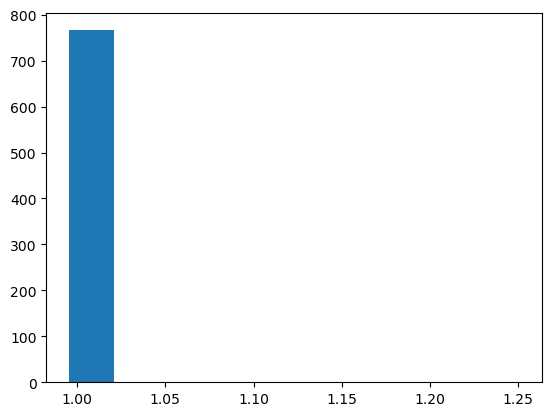

In [343]:
plt.hist(Slopes(torch.LongTensor([4])).detach().numpy()[-1])

ValueError: autodetected range of [nan, nan] is not finite

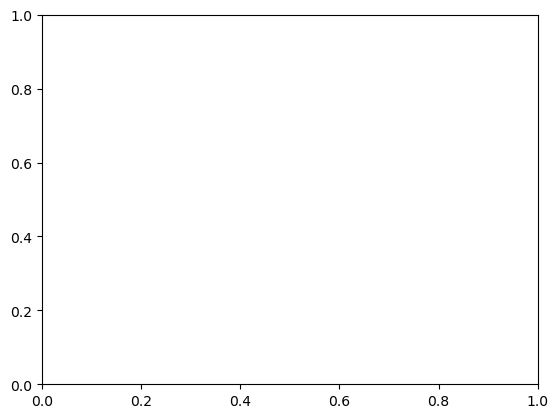

In [136]:
plt.hist(Slopes(torch.LongTensor([8])).detach().numpy()[-1])